In [1]:
import cv2 as cv
import numpy as np 
import matplotlib.pyplot as plt

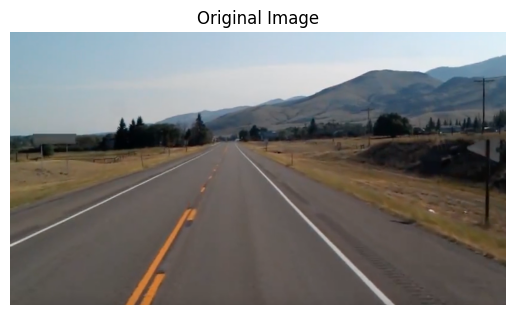

In [2]:
img = cv.imread("lane1.jpg", cv.IMREAD_UNCHANGED)
img= cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
median = np.median(img)
lower = int(max(0, 0.66 * median))
upper = int(min(255, 1.33 * median))

(np.float64(-0.5), np.float64(1278.5), np.float64(703.5), np.float64(-0.5))

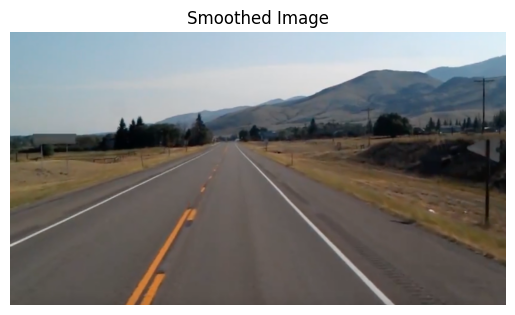

In [3]:
img_blur = cv.medianBlur(img, 3)
plt.imshow(img_blur)
plt.title("Smoothed Image")
plt.axis('off')

In [4]:
def hough_transform_line(img, edge_low=100, edge_high=200, rho_res=1, theta_res=1, use_mask=False):

    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY) if len(img.shape) == 3 else img
    edges = cv.Canny(gray, edge_low, edge_high)

    if use_mask:
        height, width = edges.shape
        mask = np.zeros_like(edges)

        if len(img.shape) > 2:
            channel_count = img.shape[2]
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        bottom_left  = [width * 0.01, height * 0.95]
        top_left     = [width * 0.08, height * 0.5]
        top_right    = [width * 0.7, height * 0.5]
        bottom_right = [width * 0.9, height * 0.95]

        vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
        cv.fillPoly(mask, vertices, ignore_mask_color)
        edges_masked = cv.bitwise_and(edges, mask)


    height, width = edges_masked.shape
    diag_len = int(np.hypot(height, width))  # maximum possible rho

    rhos = np.arange(-diag_len, diag_len + 1, rho_res)
    thetas = np.deg2rad(np.arange(0, 180, theta_res))

    accumulator = np.zeros((len(rhos), len(thetas)))

    y_idxs, x_idxs = np.nonzero(edges_masked)

    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx in range(len(thetas)):
            rho = int(round(x * np.cos(thetas[t_idx]) + y * np.sin(thetas[t_idx]))) + diag_len
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos, mask, edges, edges_masked


def hough_apply_line(img, accumulator, thetas, rhos, peak_ratio=0.4, line_color=(0, 255, 0)):

    img_copy = img.copy()
    height, width = img.shape[:2]

    # Only keep strong peaks
    threshold = np.max(accumulator) * peak_ratio
    peaks = np.argwhere(accumulator > threshold)

    best_rhos = []
    best_thetas = []


    for rho_idx, theta_idx in peaks:
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]
        # print(f"rho: {rho}, theta: {theta}")

        # Avoid duplicates (optional)
        if any(abs(theta - t) < np.deg2rad(5) for t in best_thetas):
            continue

        best_rhos.append(rho)
        best_thetas.append(theta)

        # Convert rho/theta to line endpoints
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        length = max(width, height) * 2  # extend line beyond image

        x1 = int(x0 + length * (-b))
        y1 = int(y0 + length * (a))
        x2 = int(x0 - length * (-b))
        y2 = int(y0 - length * (a))

        cv.line(img_copy, (x1, y1), (x2, y2), line_color, 8)
     
    return img_copy, best_thetas, best_rhos


Text(0.5, 1.0, 'Mask')

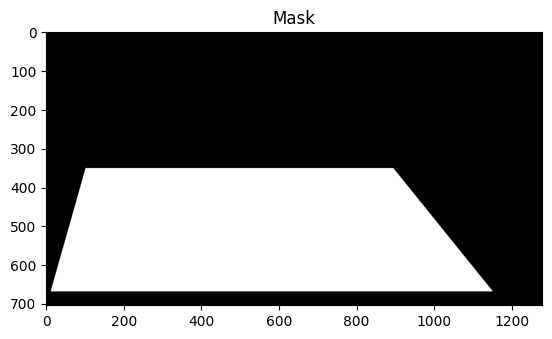

In [5]:
accumulator, thetas, rhos, mask, edges, edges_masked = hough_transform_line(img_blur, use_mask= True)
img_lines, best_thetas, best_rhos = hough_apply_line(img_blur, accumulator, thetas, rhos)
plt.imshow(mask, cmap='gray')
plt.title("Mask")

(np.float64(-0.5), np.float64(1278.5), np.float64(703.5), np.float64(-0.5))

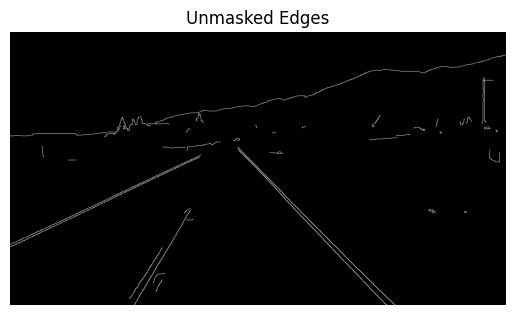

In [6]:
plt.imshow(edges, cmap='gray')
plt.title("Unmasked Edges")
plt.axis('off')

(np.float64(-0.5), np.float64(1278.5), np.float64(703.5), np.float64(-0.5))

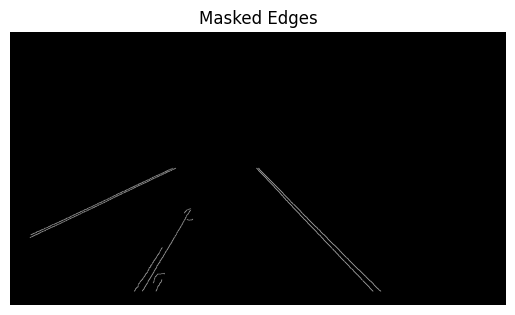

In [7]:
plt.imshow(edges_masked, cmap='gray')
plt.title("Masked Edges")
plt.axis('off')

In [8]:
print("Accumulator shape:", accumulator.shape)
print("Max value in accumulator:", np.max(accumulator))
print("Number of non-zero bins:", np.count_nonzero(accumulator))

Accumulator shape: (2919, 180)
Max value in accumulator: 353.0
Number of non-zero bins: 99007


(np.float64(-0.5), np.float64(1278.5), np.float64(703.5), np.float64(-0.5))

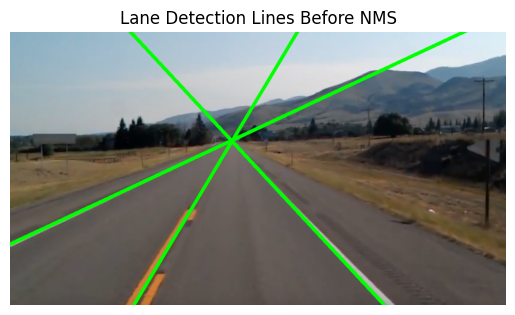

In [9]:
plt.imshow(img_lines)
plt.title("Lane Detection Lines Before NMS")
plt.axis('off')

Text(0.5, 1.0, 'Accumulator')

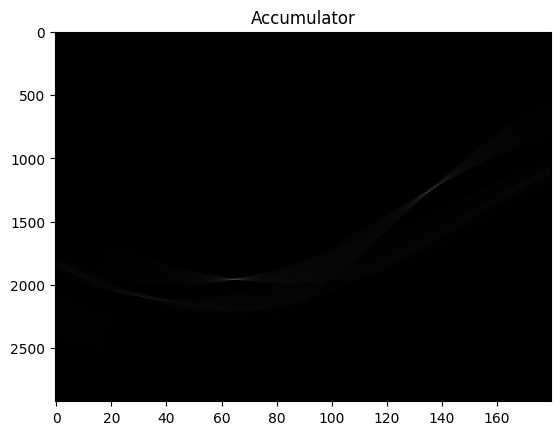

In [10]:
plt.imshow(accumulator, cmap='gray', aspect='auto')
plt.title("Accumulator")

In [11]:
from scipy.ndimage import maximum_filter

def non_max_suppression_accumulator(accumulator, neighborhood_size, threshold_ratio):

    # Copy accumulator so we don’t modify the original
    acc = accumulator.copy()
    
    # Determine threshold based on maximum value
    max_val = np.max(acc)
    threshold = max_val * threshold_ratio
    
    # Create a mask of local maxima using a max filter
    local_max = maximum_filter(acc, size=neighborhood_size) == acc
    
    # Apply both threshold and local maxima conditions
    suppressed = np.zeros_like(acc)
    suppressed[(acc >= threshold) & local_max] = acc[(acc >= threshold) & local_max]
    
    return suppressed


(np.float64(-0.5), np.float64(1278.5), np.float64(703.5), np.float64(-0.5))

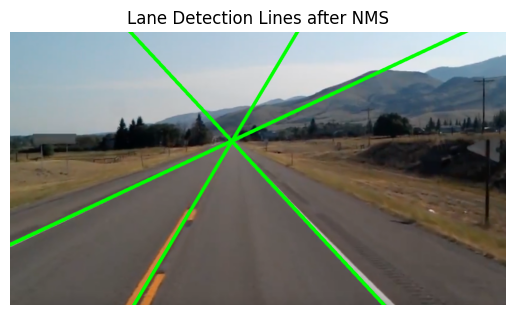

In [12]:
accumulator_nms = non_max_suppression_accumulator(accumulator, neighborhood_size=7, threshold_ratio=0.5)
img_lines_new, best_thetas_new, best_rhos_new = hough_apply_line(img_blur, accumulator_nms, thetas, rhos)
plt.imshow(img_lines_new)
plt.title("Lane Detection Lines after NMS")
plt.axis('off')

In [13]:
print("Suppressed shape:", accumulator_nms.shape)
print("Non-zero peaks:", np.count_nonzero(accumulator_nms))
print("Peak locations:", np.argwhere(accumulator_nms > 0))

Suppressed shape: (2919, 180)
Non-zero peaks: 5
Peak locations: [[1234  137]
 [1249  136]
 [1257  135]
 [1956   65]
 [2095   31]]


Text(0.5, 1.0, 'Accumulator after NMS')

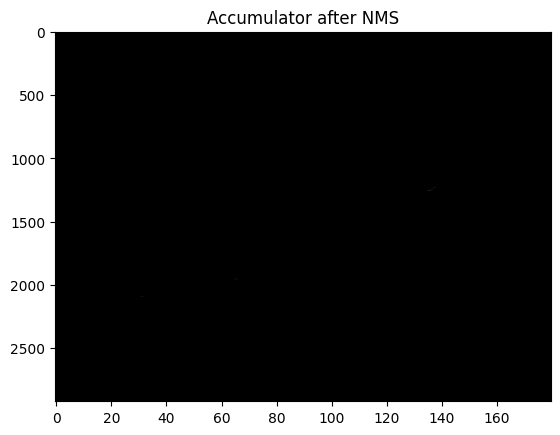

In [14]:
plt.imshow(accumulator_nms, cmap='gray', aspect='auto')
plt.title("Accumulator after NMS")